In [1]:
#pip install keras

In [2]:
#!pip install keras-tuner

In [3]:
#!pip3 install tensorflow

In [4]:
#!pip install keras-models

In [5]:
#!pip install xgboost

In [6]:
# Import our dependencies
from datetime import datetime

import os
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, GRU, Flatten, LSTM
from keras.optimizers import *


## QuestDB dependencies
import io
import requests
import urllib.parse as par

In [7]:
# Read the dataset
pos_data = pd.read_csv("Hist_POS_data.csv")

In [8]:
pos_data.head()

,MemberDate,Year,Week,UPC12digit,Prod_Desc,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
0,1/8/2017,2017,1,631656601931,Hyd Original 60ct US,HYD,DIET,WEIGHT LOSS,10515.0,NaN,...,NaN,84.1,3552.0,3.0,0.0,0.0,141099.00,0.0,141099.00,-
1,1/8/2017,2017,1,631656602351,Hyd Non-Stimulant 60ct US,HYD,DIET,WEIGHT LOSS,3466.0,NaN,...,NaN,55.1,2187.0,1.6,0.0,0.0,141099.00,0.0,141099.00,-
2,1/8/2017,2017,1,631656602521,Hyd + Women 60ct US,HYD,DIET,WEIGHT LOSS,4145.0,NaN,...,NaN,61.8,2536.0,1.6,0.0,0.0,141099.00,0.0,141099.00,-
3,1/8/2017,2017,1,631656602621,SS N.O. Fury 60ct US,SS,PERFORMANCE NUTRITION,PREWORKOUT,5840.0,NaN,...,NaN,71.4,3027.0,1.9,0.0,0.0,52347.00,0.0,52347.00,-
4,1/8/2017,2017,1,631656602631,SS Creatine X3 60ct US,SS,PERFORMANCE NUTRITION,CREATINE,6044.0,NaN,...,NaN,70.6,3040.0,2.0,0.0,0.0,21533.00,0.0,21533.00,-


In [9]:
#Check data types
pos_data.dtypes

MemberDate                          object
Year                                 int64
Week                                 int64
UPC12digit                           int64
Prod_Desc                           object
Brand                               object
ioCategory                          object
ioSubCategory                       object
Unit_Sales                         float64
Unit % Chg                         float64
YA_Unit_Sales                       object
4-Week_Moving Avg_Units            float64
%_Chg_from_MA                      float64
Average Weekly ACV Distribution    float64
Number of Stores Selling           float64
U/S/W                              float64
Number of Stores Selling YA        float64
U/S/W YA                           float64
Sub_Cat_Units                       object
Sub_Cat_%_Chg                      float64
Sub_Cat_Units_YA                    object
Sub_Cat_MA_Units                    object
dtype: object

In [10]:
#Correct the data types where needed
pos_data['MemberDate']= pd.to_datetime(pos_data['MemberDate'])
#pos_data['MemberDate'] = pos_data['MemberDate'].dt.strftime('%Y-%U')
pos_data['UPC12digit'] = pos_data['UPC12digit'].astype(str)
pos_data['YA_Unit_Sales'] = pd.to_numeric(pos_data['YA_Unit_Sales'],errors = 'coerce')
pos_data['Sub_Cat_Units'] = pd.to_numeric(pos_data['Sub_Cat_Units'],errors = 'coerce')
pos_data['Sub_Cat_Units_YA'] = pd.to_numeric(pos_data['Sub_Cat_Units_YA'],errors = 'coerce')
pos_data['Sub_Cat_MA_Units'] = pd.to_numeric(pos_data['Sub_Cat_MA_Units'],errors = 'coerce')


In [11]:
#Check data types
pos_data.dtypes

MemberDate                         datetime64[ns]
Year                                        int64
Week                                        int64
UPC12digit                                 object
Prod_Desc                                  object
Brand                                      object
ioCategory                                 object
ioSubCategory                              object
Unit_Sales                                float64
Unit % Chg                                float64
YA_Unit_Sales                             float64
4-Week_Moving Avg_Units                   float64
%_Chg_from_MA                             float64
Average Weekly ACV Distribution           float64
Number of Stores Selling                  float64
U/S/W                                     float64
Number of Stores Selling YA               float64
U/S/W YA                                  float64
Sub_Cat_Units                             float64
Sub_Cat_%_Chg                             float64


In [12]:
#Filter out 2017 Data
filtered_pos = pos_data[pos_data['MemberDate'] > '2017-12-31']
filtered_pos.head()

,MemberDate,Year,Week,UPC12digit,Prod_Desc,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
3042,2018-01-07,2018,1,631656601931,Hyd Original 60ct US,HYD,DIET,WEIGHT LOSS,5172.0,-0.51,...,0.03,65.0,2783.0,1.9,3551.98,2.96,128223.0,-2.99,511280.0,97434.0
3043,2018-01-07,2018,1,631656602351,Hyd Non-Stimulant 60ct US,HYD,DIET,WEIGHT LOSS,2118.0,-0.39,...,0.19,39.6,1620.0,1.3,2186.63,1.59,128223.0,-2.99,511280.0,97434.0
3044,2018-01-07,2018,1,631656602521,Hyd + Women 60ct US,HYD,DIET,WEIGHT LOSS,4152.0,0.00,...,0.32,60.7,2527.0,1.6,2535.73,1.63,128223.0,-2.99,511280.0,97434.0
3045,2018-01-07,2018,1,631656602621,SS N.O. Fury 60ct US,SS,PERFORMANCE NUTRITION,PREWORKOUT,4770.0,-0.18,...,0.04,65.6,2752.0,1.7,3026.84,1.93,50186.0,-0.04,52258.0,46270.0
3046,2018-01-07,2018,1,631656602631,SS Creatine X3 60ct US,SS,PERFORMANCE NUTRITION,CREATINE,4739.0,-0.22,...,0.01,63.1,2700.0,1.8,3039.80,1.99,18169.0,-0.16,21007.0,17032.0


Graph unit sales trend over time to display complexity of forecasting

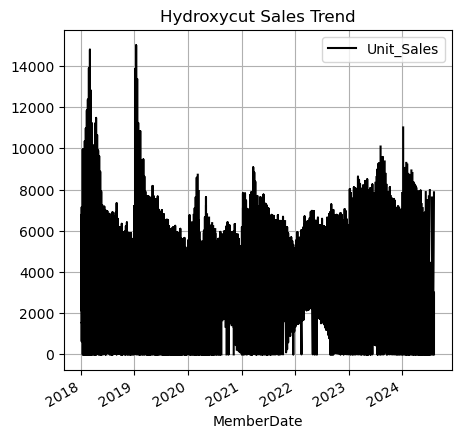

In [13]:
hyd_pos = filtered_pos[filtered_pos['Brand'] == 'HYD']
hyd_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="Hydroxycut Sales Trend", color = 'black')
plt.show()

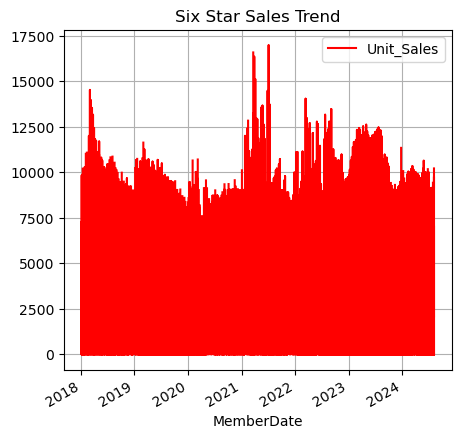

In [14]:
ss_pos = filtered_pos[filtered_pos['Brand'] == 'SS']
ss_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="Six Star Sales Trend", color = 'red')
plt.show()

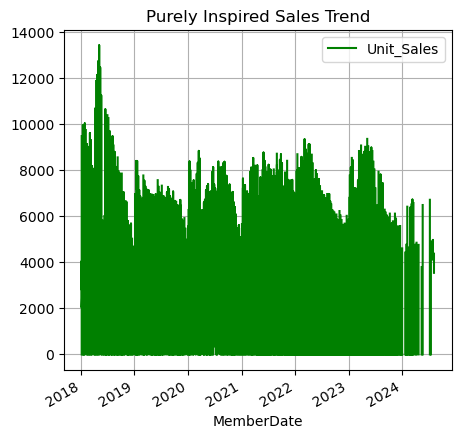

In [15]:
pi_pos = filtered_pos[filtered_pos['Brand'] == 'PI']
pi_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="Purely Inspired Sales Trend", color = 'green')
plt.show()

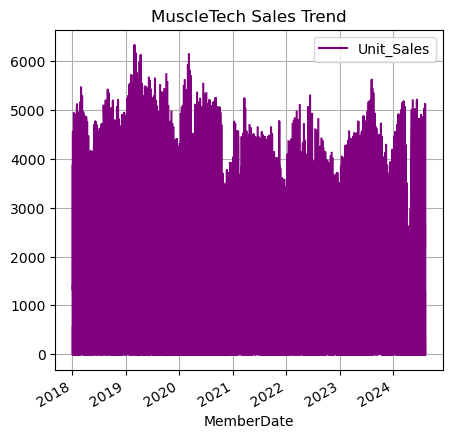

In [16]:
mt_pos = filtered_pos[filtered_pos['Brand'] == 'MT']
mt_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="MuscleTech Sales Trend", color = 'purple')
plt.show()

Create a Nueral Network Model using previous years unit sales data to predict future sales

In [17]:
hc_hyd_pos = filtered_pos[filtered_pos['UPC12digit'] == '631656603201']
hc_hyd_pos.head()

,MemberDate,Year,Week,UPC12digit,Prod_Desc,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
3048,2018-01-07,2018,1,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6791.0,0.01,...,0.21,75.4,3258.0,2.1,3192.85,2.11,128223.0,-2.99,511280.0,97434.0
3116,2018-01-14,2018,2,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,7149.0,0.03,...,0.23,76.2,3288.0,2.2,3244.89,2.14,145356.0,-0.01,146818.0,102395.0
3186,2018-01-21,2018,3,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6864.0,-0.07,...,0.10,75.0,3232.0,2.1,3357.76,2.19,136941.0,-0.11,152036.0,114779.0
3255,2018-01-28,2018,4,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6966.0,-0.07,...,0.07,76.5,3310.0,2.1,3360.91,2.24,150951.0,-0.03,155109.0,125142.0
3321,2018-02-04,2018,5,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,7232.0,-0.11,...,0.04,76.7,3319.0,2.2,3454.91,2.36,154338.0,-0.08,167070.0,140368.0


In [18]:
hc_hyd_pos['sales_diff'] = hc_hyd_pos['Unit_Sales'].diff()
hc_hyd_pos = hc_hyd_pos.dropna()
hc_hyd_pos.head()

C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_45268\2455506681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_hyd_pos['sales_diff'] = hc_hyd_pos['Unit_Sales'].diff()


,MemberDate,Year,Week,UPC12digit,Prod_Desc,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,...,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units,sales_diff
3116,2018-01-14,2018,2,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,7149.0,0.03,...,76.2,3288.0,2.2,3244.89,2.14,145356.0,-0.01,146818.0,102395.0,358.0
3186,2018-01-21,2018,3,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6864.0,-0.07,...,75.0,3232.0,2.1,3357.76,2.19,136941.0,-0.11,152036.0,114779.0,-285.0
3255,2018-01-28,2018,4,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6966.0,-0.07,...,76.5,3310.0,2.1,3360.91,2.24,150951.0,-0.03,155109.0,125142.0,102.0
3321,2018-02-04,2018,5,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,7232.0,-0.11,...,76.7,3319.0,2.2,3454.91,2.36,154338.0,-0.08,167070.0,140368.0,266.0
3387,2018-02-11,2018,6,631656603201,Hyd Hardcore 60ct US,HYD,DIET,WEIGHT LOSS,6638.0,-0.19,...,74.8,3256.0,2.0,3456.92,2.36,149535.0,-0.09,162527.0,146897.0,-594.0


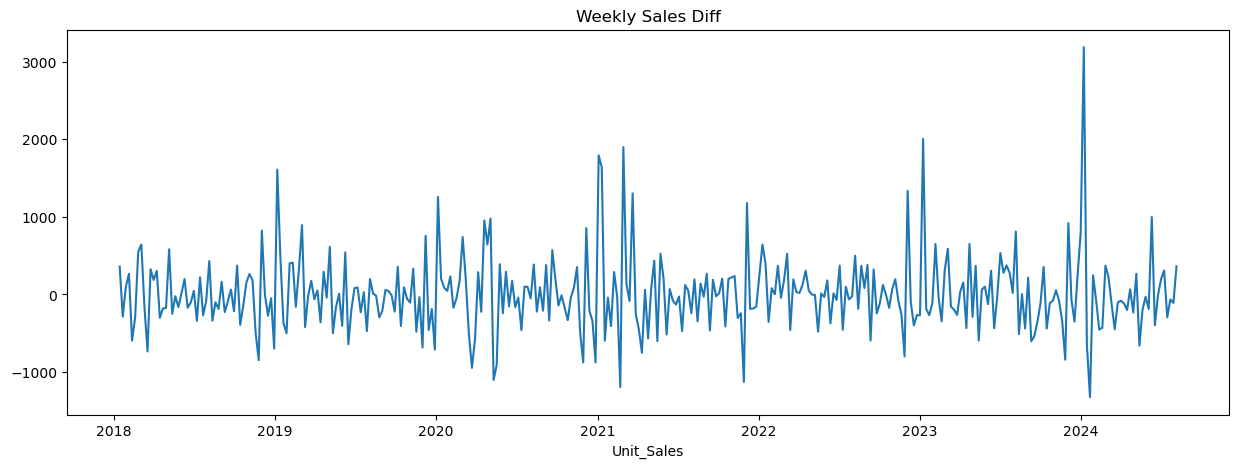

In [19]:
plt.figure(figsize=(15,5))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['sales_diff'])
plt.xlabel('MemberDate')
plt.xlabel('Unit_Sales')
plt.title("Weekly Sales Diff")
plt.show()

In [20]:
# Select categorization and YA unit sales columns to use as X data
Selected_Columns = hc_hyd_pos[['sales_diff']]
Selected_Columns.head()

,sales_diff
3116,358.0
3186,-285.0
3255,102.0
3321,266.0
3387,-594.0


In [21]:
#Capture sales_diff for the past 4 years in weeks
for i in range(1,312):
    col_name = 'week_' + str(i)
    Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
Selected_Columns = Selected_Columns.dropna().reset_index(drop=True)
Selected_Columns.head(10)

C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_45268\3936272625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_45268\3936272625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_45268\3936272625.py:4: SettingWithCopyWarning: 
A value is trying to be set o

,sales_diff,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,...,week_302,week_303,week_304,week_305,week_306,week_307,week_308,week_309,week_310,week_311
0,-1322.0,-647.0,3186.0,803.0,255.0,-351.0,-69.0,919.0,-841.0,-344.0,...,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0,-285.0,358.0
1,246.0,-1322.0,-647.0,3186.0,803.0,255.0,-351.0,-69.0,919.0,-841.0,...,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0,-285.0
2,-81.0,246.0,-1322.0,-647.0,3186.0,803.0,255.0,-351.0,-69.0,919.0,...,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0
3,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,803.0,255.0,-351.0,-69.0,...,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0
4,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,803.0,255.0,-351.0,...,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0
5,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,803.0,255.0,...,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0
6,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,803.0,...,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0
7,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,...,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0
8,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,...,-249.0,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0
9,-103.0,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,...,-23.0,-249.0,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0


In [22]:
#Split the data into train and test
train_data = Selected_Columns[:-12]
test_data = Selected_Columns[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (17, 312)
Test Data Shape: (12, 312)


In [23]:
#Scale the data
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)



MinMaxScaler(feature_range=(-1, 1))

In [24]:
#transform the data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [25]:
#Split the data into X and y
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (17, 311)
y_train Shape: (17,)
X_test Shape: (12, 311)
y_test Shape: (12,)


In [26]:
#Create a dataframe for the predictions
sales_dates = hc_hyd_pos['MemberDate'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
predict_df

,MemberDate
0,2024-05-19
1,2024-05-26
2,2024-06-02
3,2024-06-09
4,2024-06-16
5,2024-06-23
6,2024-06-30
7,2024-07-07
8,2024-07-14
9,2024-07-21


In [27]:
#Capture the actual sales for the last 12 weeks to compare to the predictions
act_sales = hc_hyd_pos['Unit_Sales'][-12:].to_list()
act_sales

[7101.0,
 7071.0,
 6884.0,
 7881.0,
 7484.0,
 7472.0,
 7669.0,
 7978.0,
 7683.0,
 7618.0,
 7508.0,
 7870.0]

Linear Regression Test

In [28]:
#Fit Linear Regression Model
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

#Transform
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

#Predict
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

#Results
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)



Linear Regression RMSE:  221.01791808808127
Linear Regression MAE:  180.78670265843866
Linear Regression R2 Score:  0.6475833942673652


In [29]:
predict_df

,MemberDate,linreg_pred
0,2024-05-19,6761.570813
1,2024-05-26,7068.967946
2,2024-06-02,6827.268683
3,2024-06-09,7695.333922
4,2024-06-16,7203.858255
5,2024-06-23,7130.984852
6,2024-06-30,7653.319886
7,2024-07-07,7792.886331
8,2024-07-14,7488.131154
9,2024-07-21,7240.798914


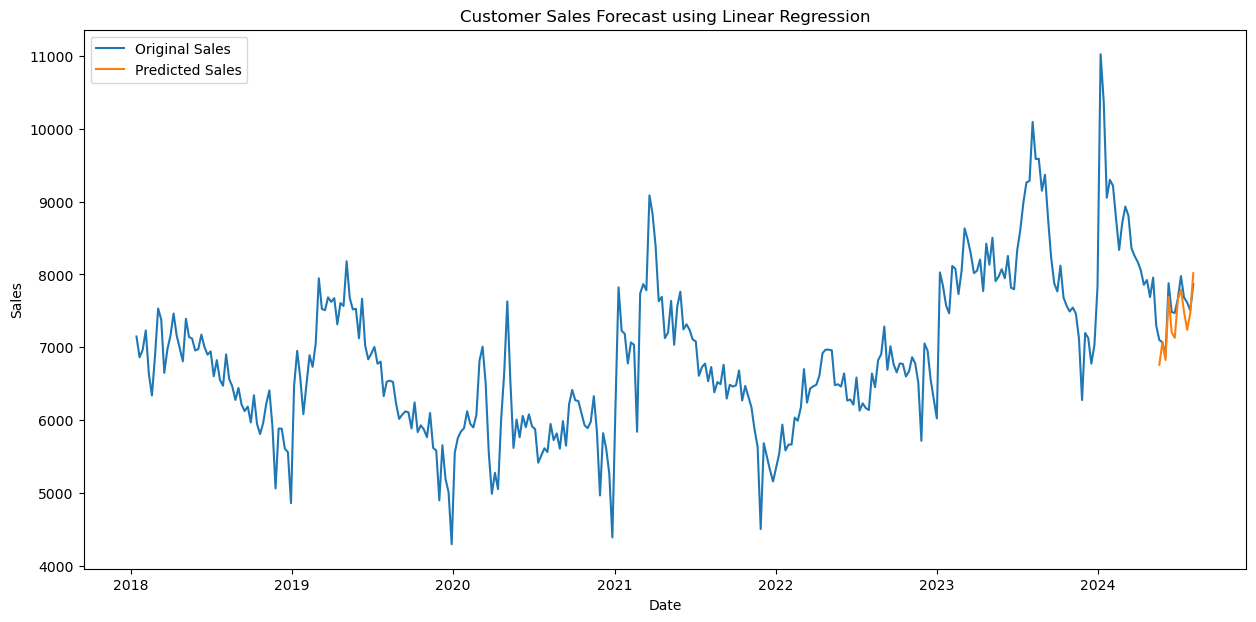

In [30]:
#Visualize Linear Regression Results
plt.figure(figsize=(15,7))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['Unit_Sales'])
plt.plot(predict_df['MemberDate'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

Random Forest Regressor Test

In [ ]:
# Select categorization and YA unit sales columns to use as X data
Selected_Columns = hc_hyd_pos[['Year','Week','sales_diff']]

# Create X_df using your selected columns
X = Selected_Columns

X.dtypes

In [ ]:
#Select y column
y = hc_hyd_pos['Unit_Sales']

In [ ]:
X.dtypes

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
## Scale
X_scaler = MinMaxScaler()

#train_scaled = scaler.fit_transform(train)
#test_scaled = scaler.transform(X_test)

X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## train data
#y_train = train_scaled[:,-1]
X_train = X_train_scaled[:,0:-1]
#X_train = X_train.reshape(len(X_train),1,1)

## test data
#y_test = test_scaled[:,-1]
X_test = X_test_scaled[:,0:-1]


# Create scaler instance
#X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
#X_scaler.fit(X_train)

# Scale the data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [ ]:
model = tf.keras.models.Sequential()    
model.add(LSTM(64, input_shape=(33, 1), return_sequences=False))
model.add(Dense(1))
    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['accuracy']        
)

In [ ]:
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=10, 
    batch_size=4096,
    verbose=1, 
    shuffle=True,
    validation_split=0.4)

In [ ]:
## GRU Model
model = Sequential()
## GRU layer
model.add(GRU(75, input_shape=(1,1)))
## output layer
model.add(Dense(1))
#optimizer = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=20, batch_size=20, shuffle=False)

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    ya_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    ya_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=len(X.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        ya_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    ya_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    ya_model.compile(loss="MeanSquaredError", optimizer='adam', metrics=["accuracy"])

    return ya_model

In [ ]:
ya_tuner = kt.Hyperband(
    create_model,
    objective=kt.Objective('accuracy',direction='max'),
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
# Run the kerastuner search for best hyperparameters
ya_tuner.search(X_train_scaled,y_train,epochs=50,validation_data=(X_test_scaled,y_test))

In [ ]:
# Get best model hyperparameters
best_hyper = ya_tuner.get_best_hyperparameters(1)[0]
best_hyper.values

In [ ]:
# Evaluate best model against full test data
best_model = ya_tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")